#**HOMEWORK: BLUE BIKE TRIP DURATION PREDICTION (Total: / 15 points)**

Context: You have received some data from Blue Bikes (the Boston Bikesharing Service). They have asked you to provide a predictive model that can accurately predict how long a given bike rental will last, at the time the rental begins. The use case is that the bike share company wants to be able to predict how long a customer will have the bike in their possession, when they begin their retnal, in order to better manage operational efficiency across the bike network. Note that when the customer initiates a bike rental, they enter the starting station ID and ending station ID for their trip, into the mobile app.

# *Name: Tao Li*
# *Email: taoli@bu.edu*

#*Import and Pre-process Data*

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [3]:
def vectorize_categorical(sequences, categories_mapping):
    # Make our blank matrix of 0's to store hot encodings.
    results = np.zeros((len(sequences), len(categories_mapping)))

    # For each observation and element in that observation,
    # Update the blank matrix to a 1 at row obs, column element value.
    for i, category in enumerate(sequences):
        results[i, categories_mapping[category]] = 1.
    return results


In [4]:
# import dataset
bluebikes = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2023/main/Lecture%20Materials/C_Assignment/bluebikes_sample.csv')

# This function MUST return a pair of objects (predictors, labels, in that order) as numpy arrays.
def processData(data):
    
    # pre-process your data here, and return your two numpy arrays...
    # 遍历数据集，对每个 starttime 字段进行处理
    for i, row in data.iterrows():
        # read starttime
        time_str = row['starttime']
        
        # transform time into datatime type
        time_obj = datetime.strptime(time_str, '%M:%S.%f')
        
        # extract minutes and seconds, and calculate the start seconds
        minutes = time_obj.minute
        seconds = time_obj.second + (minutes * 60)
        
        # store start_seconds in the dataset
        data.at[i, 'start_seconds'] = seconds

    # Create mapping for usertype and gender
    usertype_mapping = {value: index for index, value in enumerate(data['usertype'].unique())}
    gender_mapping = {value: index for index, value in enumerate(data['gender'].unique())}

    # Convert categorical features to one-hot encoding
    usertype_onehot = vectorize_categorical(data['usertype'], usertype_mapping)
    gender_onehot = vectorize_categorical(data['gender'], gender_mapping)

    print("Usertype one-hot shape:", usertype_onehot.shape)
    print("Gender one-hot shape:", gender_onehot.shape)

    # Select the relevant features
    # Merge one-hot features with other features
    predictors = data[['start_seconds', 
                       'start station id', 
                       'end station id', 
                       'start station latitude', 
                       'start station longitude', 
                       'end station latitude', 
                       'end station longitude', 
                       'birth year', 'bikeid']]
    
    # Scale the numerical features
    scaler = StandardScaler()
    numerical_features = scaler.fit_transform(predictors)

    # Merge one-hot features with other features
    train_predictors = np.concatenate([numerical_features, usertype_onehot, gender_onehot], axis=1)
    train_labels = data['tripduration'].values

    return train_predictors, train_labels


In [ ]:
# Check if there is null value in the dataset
bluebikes.isnull().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
dtype: int64

In [ ]:
# Find the max time, starttime and stoptime seem not to be 24 hour metrics
bluebikes['stoptime'].max()

Timestamp('1900-01-01 00:59:59.700000')

In [30]:
# Print the head of the dataframe
bluebikes.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,bikeid,usertype,birth year,gender,start_minutes,start_seconds,start_milliseconds,stop_minutes,stop_seconds,stop_milliseconds
0,1584,09:36.7,36:00.9,442,Hyde Park Ave at Walk Hill St,42.296067,-71.116012,122,Burlington Ave at Brookline Ave,42.345733,...,4587,Subscriber,1967,1,9.0,36.0,700.0,36.0,0.0,900.0
1,894,40:48.2,55:43.0,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,144,Rogers St & Land Blvd,42.365758,...,2340,Subscriber,1994,1,40.0,48.0,200.0,55.0,43.0,0.0
2,973,58:05.4,14:18.4,57,Columbus Ave at Massachusetts Ave,42.340543,-71.081388,68,Central Square at Mass Ave / Essex St,42.365070,...,2910,Subscriber,1994,1,58.0,5.0,400.0,14.0,18.0,400.0
3,606,46:45.0,56:51.4,149,175 N Harvard St,42.363796,-71.129164,221,Verizon Innovation Hub 10 Ware Street,42.372509,...,4526,Subscriber,1992,1,46.0,45.0,0.0,56.0,51.0,400.0
4,428,49:27.9,56:36.7,426,Surface Rd at Summer St,42.352946,-71.056564,420,Charles St at Pinckney St,42.358725,...,3780,Subscriber,1989,1,49.0,27.0,900.0,56.0,36.0,700.0


In [ ]:
bluebikes.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
dtype: object

#*Specify Your Neural Network Architecture, Process Your Sample*

Calling the data pre-processing function on the sample.

In [5]:
predictors, labels = processData(bluebikes)

Usertype one-hot shape: (9000, 2)
Gender one-hot shape: (9000, 3)


Specifying my Neural Network's structure. Note that the important thing for performance with this model actually comes down to its depth! It turns out that width isn't that important here. 


In [9]:
# Can install the tensorflow-addons package in your colab runtime. 
try:
    import tensorflow_addons as tfa                     
except ImportError:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [20]:
def build_model():
    
    # specify your model architecture here using the Keras sequential API
    # compile your model, specifying the loss and other metrics you might want to track, plus the optimizer

    # Create the neural network model
    # Among 'relu', 'elu', 'tanh' and 'sigmoid', 'elu' seems to work better 
    # than other, and 'tanh' and ' sigmoid' may cause vanishing gradient.
    # I try adding leakyrelu, and random normal noise to the input features, 
    # but it did not work good.
    model = keras.Sequential([
        keras.layers.Dense(128,activation="elu"), 
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='elu'), 
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation='elu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='elu'), 
        keras.layers.Dense(1)
    ])

    # Compile the model
    model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
    
    return model

#*Train Your Neural Network Here*

In [21]:
model = build_model()

history = model.fit(predictors, labels, epochs=50, batch_size=32, validation_split=0.2) ## specify your data and other parameters here for model fit 

Epoch 1/50
225/225 [==============================] - 4s 7ms/step - loss: 642.4517 - mae: 642.4517 - val_loss: 525.8610 - val_mae: 525.8610
Epoch 2/50
225/225 [==============================] - 2s 7ms/step - loss: 472.4915 - mae: 472.4915 - val_loss: 462.3688 - val_mae: 462.3688
Epoch 3/50
225/225 [==============================] - 1s 5ms/step - loss: 417.8079 - mae: 417.8079 - val_loss: 399.5786 - val_mae: 399.5786
Epoch 4/50
225/225 [==============================] - 1s 5ms/step - loss: 392.3574 - mae: 392.3574 - val_loss: 392.3394 - val_mae: 392.3394
Epoch 5/50
225/225 [==============================] - 1s 5ms/step - loss: 383.6555 - mae: 383.6555 - val_loss: 384.0981 - val_mae: 384.0981
Epoch 6/50
225/225 [==============================] - 1s 5ms/step - loss: 376.5811 - mae: 376.5811 - val_loss: 378.2573 - val_mae: 378.2573
Epoch 7/50
225/225 [==============================] - 1s 5ms/step - loss: 372.9666 - mae: 372.9666 - val_loss: 375.6936 - val_mae: 375.6936
Epoch 8/50
225/225 [

Plot your model performance over training here:

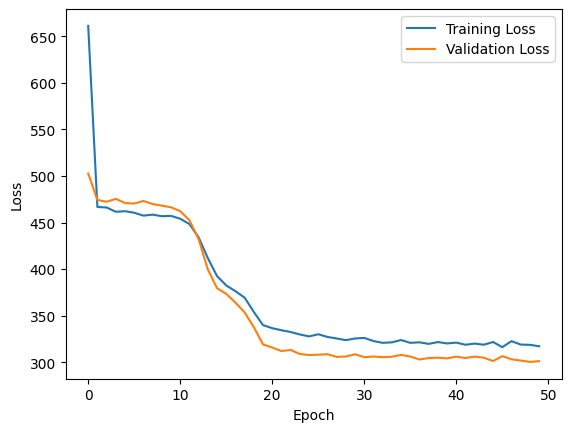

In [8]:
import matplotlib.pyplot as plt

# Build your plot.
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.show()

#*Choose Final Configuration and Produce That Model Here:*

In [22]:
model = build_model()
model.fit(predictors,labels,epochs=80, batch_size=50) # for example

Epoch 1/80
180/180 [==============================] - 3s 4ms/step - loss: 680.8119 - mae: 680.8119
Epoch 2/80
180/180 [==============================] - 1s 4ms/step - loss: 501.2426 - mae: 501.2426
Epoch 3/80
180/180 [==============================] - 1s 4ms/step - loss: 438.9584 - mae: 438.9584
Epoch 4/80
180/180 [==============================] - 1s 4ms/step - loss: 377.1954 - mae: 377.1954
Epoch 5/80
180/180 [==============================] - 1s 4ms/step - loss: 336.5376 - mae: 336.5376
Epoch 6/80
180/180 [==============================] - 1s 4ms/step - loss: 324.5050 - mae: 324.5050
Epoch 7/80
180/180 [==============================] - 1s 4ms/step - loss: 322.3705 - mae: 322.3705
Epoch 8/80
180/180 [==============================] - 1s 5ms/step - loss: 320.7081 - mae: 320.7081
Epoch 9/80
180/180 [==============================] - 1s 5ms/step - loss: 317.5739 - mae: 317.5739
Epoch 10/80
180/180 [==============================] - 1s 5ms/step - loss: 316.4550 - mae: 316.4550
Epoch 11/

Here's what the resulting model looks like.

In [23]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (50, 128)                 1920      
                                                                 
 batch_normalization_14 (Bat  (50, 128)                512       
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (50, 128)                 16512     
                                                                 
 batch_normalization_15 (Bat  (50, 128)                512       
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (50, 64)                  8256      
                                                                 
 dropout_7 (Dropout)         (50, 64)                 

#*Final Evaluation*

Don't modify this section; this is the code I will use to evaluate that your model is output properly and that it can generate predictions on new test observations it has never seen before. If your model breaks when I feed it the new data, I will deduct marks, so please ensure that your data pre-processing function works properly!

In [24]:
from google.colab import files
import io

# I'm going to upload my holdout dataset (same set of features)
uploaded = files.upload()
bluebike_holdout = pd.read_csv(io.BytesIO(uploaded['bluebikes_holdout.csv']))

# I'm then going to pre-process it using your commands.
holdout_predictors, holdout_labels = processData(bluebike_holdout)

# Then I'm going to evaluate your model's performance on that data.
loss_metrics = model.evaluate(holdout_predictors,holdout_labels,verbose=1)

KeyboardInterrupt: ignored